In [51]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as tick
import itertools
from sklearn import linear_model
import os
import random as rn
from keras import backend as K
import tensorflow as tf
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout
from tensorflow.compat.v1.keras.optimizers import SGD, RMSprop, Adadelta

In [52]:
df = pd.read_csv("./data/measurements.csv", decimal=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      376 non-null float64
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null float64
refill gas       13 non-null object
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


In [53]:
df.isnull().sum()

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64

* gas_typeがE10, SP98の二種類なので0と1にダミー変数化
* temp_insideに欠損値があるため平均で埋める
* 説明変数は['distance', "speed", 'temp_inside' , 'temp_outside', 'gas_type', 'AC', 'rain', 'sun']を使用
    - specialsはAC, rain, sunがあるため不採用
    - refill liters, refill gassは欠損値が多すぎるため不採用

In [54]:
# ダミー変数
df['gas_type'] = pd.get_dummies(df['gas_type'])
# 欠損値を平均で埋める
df['temp_inside'] = df['temp_inside'].fillna(df['temp_inside'].mean())
# 目的変数と説明変数の設定
target = df['consume']
data = df.loc[:, ['distance', "speed", 'temp_inside' , 'temp_outside', 'gas_type', 'AC', 'rain', 'sun']]

In [55]:
(data_train, data_test, target_train, target_test) = train_test_split(data, target, test_size=0.2, random_state=666)

data_train = (data_train - data_train.mean()) / data_train.std()
data_test = (data_test - data_test.mean()) / data_test.std()

day2での結果（L1正則化を行った線形回帰）

In [56]:
clf = linear_model.Lasso(alpha=0.02, fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
clf.fit(data_train, target_train)
day2_result = clf.predict(data_test)

mse = metrics.mean_squared_error(target_test, day2_result)
rmse = np.sqrt(metrics.mean_squared_error(target_test, day2_result))
mae = metrics.mean_absolute_error(target_test, day2_result)
day2 = {"MSE":mse, "RMSE":rmse, "MAE":mae}
day2

{'MSE': 1.0357876860024955,
 'RMSE': 1.0177365503913551,
 'MAE': 0.5690296948528254}

ランダムフォレスト　ハイパーパラメータはGridSearchCVでグリッドサーチを行う

In [57]:
search_params = {
    'n_estimators'      : [2, 3, 5, 10, 100, 1000],
    'min_samples_leaf'  : [2, 3, 5, 10, 100, 1000],
    'min_samples_split' : [2, 3, 5, 10, 100, 1000],
    'max_depth'         : [2, 3, 5, 10, 100, 1000],
    'random_state'      : [666]
}
 
forest_gs = GridSearchCV(
    RandomForestRegressor(),
    search_params,
    cv = 3,
    n_jobs = -1,
    verbose=False
)
 
forest_gs.fit(data_train, target_train)

C:\Users\N398\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 100, 1

In [58]:
forest_gs_result = forest_gs.best_estimator_.predict(data_test)
# 二乗平均誤差
mse = metrics.mean_squared_error(target_test, forest_gs_result)
# 二乗平均平方根誤差 (RMSE)
rmse = np.sqrt(metrics.mean_squared_error(target_test, forest_gs_result))
# 平均絶対誤差 (MAE)
mae = metrics.mean_absolute_error(target_test, forest_gs_result)
forest_gs_result_list = ({"MSE":mse, "RMSE":rmse, "MAE":mae})
print(forest_gs_result_list)

{'MSE': 0.7861107168082858, 'RMSE': 0.8866288495240192, 'MAE': 0.5475662015830539}


ニューラルネットワークを一旦適当な値でやってみる

In [59]:
# ニューラルネットワーク
model = Sequential()
model.add(Dense(6, activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(seed=666), input_dim=len(data_train.keys())))
model.add(Dense(1))

optimizer = Adadelta()

model.compile(loss='mae',
            optimizer=optimizer,
            metrics=['mse', 'mae'])

In [60]:
fit = model.fit(data_train, target_train,
          epochs=1000,
          batch_size=16,validation_data=(data_test, target_test),
          verbose=0)

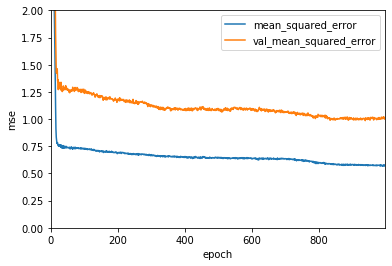

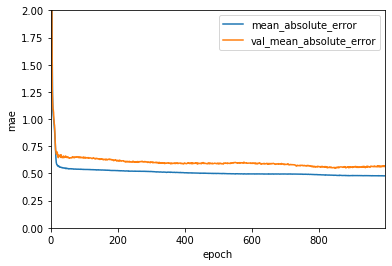

In [15]:
df_nnresult = pd.DataFrame(fit.history)

df_nnresult[['mean_squared_error', 'val_mean_squared_error']].plot()
plt.ylabel("mse")
plt.xlabel("epoch")
plt.ylim(0, 2)
plt.show()

df_nnresult[['mean_absolute_error', 'val_mean_absolute_error']].plot()
plt.ylabel("mae")
plt.xlabel("epoch")
plt.ylim(0, 2)
plt.show()


やや過学習なため、中間層にL2正則化とDropoutを入れることを検討

ハイパーパラメータはグリッドサーチを行う

In [61]:
# グリッドサーチ
def grid_search(data, target, param_list):
    (data_train, data_test, target_train, target_test) = train_test_split(data, target, test_size=0.3, random_state=666)
    data_train = (data_train - data_train.mean()) / data_train.std()
    data_test = (data_test - data_test.mean()) / data_test.std()
    
    best_score = 9999
    best_param = []
    
    # 乱数を固定
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(666)
    rn.seed(666)
    session_conf = tf.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    tf.set_random_seed(666)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    for i,param in enumerate(param_list):
        model = Sequential()
        model.add(Dense(8, activation='relu',  kernel_initializer=tf.keras.initializers.he_normal(seed=666), kernel_regularizer=keras.regularizers.l2(param[0]), input_dim=len(data_train.keys())))
        model.add(Dropout(param[1], seed=666))
        model.add(Dense(1, kernel_initializer=tf.keras.initializers.he_normal(seed=333)))

        optimizer = Adadelta()

        model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mse', 'mae'])
        fit = model.fit(data_train, target_train,
              epochs=500,
              batch_size=32,validation_data=(data_test, target_test),
              verbose=0)
        loss = model.evaluate(data_test, target_test, verbose=0)[0]
        if loss < best_score:
            best_score = loss
            best_param = param
        print(i+1, "/", len(param_list), "loss", loss, "L2", param[0], "dropout", param[1], "best_loss", best_score, "best_L2", best_param[0], "best_dropout", best_param[1])
    return best_param

In [62]:
# 処理時間の都合上一度実行した後コメントアウト　出力結果: L2 0 dropout 0.2
#
# l2 = [0, 0.1, 0.01, 0.001]
# drop_out = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
#
# param_list = list(itertools.product(l2, drop_out))
# best_param = grid_search(data, target, param_list)
#
# print("L2", best_param[0], "dropout", best_param[1])


best_param = [0, 0.2]

正則化はいらないっぽい

In [64]:
# 乱数を固定
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(666)
rn.seed(666)
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
tf.set_random_seed(666)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# モデルを作成
model2 = Sequential()
model2.add(Dense(8, activation='relu', 
                 kernel_initializer=tf.keras.initializers.he_normal(seed=666), 
                 kernel_regularizer=keras.regularizers.l2(best_param[0]), 
                 input_dim=len(data_train.keys())))
model2.add(Dropout(best_param[1], seed=666))
model2.add(Dense(1))

optimizer = Adadelta()

model2.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mse', 'mae'])

In [65]:
fit2 = model2.fit(data_train, target_train,
          epochs=1000,
          batch_size=8,
          validation_data=(data_test, target_test),
          verbose=0)

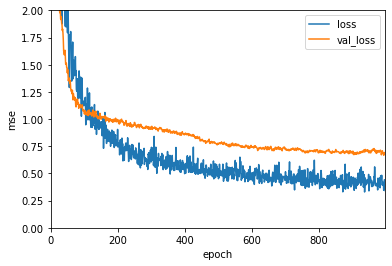

In [66]:
df_nnresult2 = pd.DataFrame(fit2.history)

df_nnresult2[['loss', 'val_loss']].plot()
plt.ylabel("mse")
plt.xlabel("epoch")
plt.ylim(0, 2)
plt.show()

In [67]:
mse = model2.evaluate(data_test, target_test, verbose=0)[1]
rmse = np.sqrt(mse)
mae = model2.evaluate(data_test, target_test, verbose=0)[2]
neural_net_result_list = ({"MSE":mse, "RMSE":rmse, "MAE":mae})
print(neural_net_result_list)

{'MSE': 0.6908487, 'RMSE': 0.83117306, 'MAE': 0.53057116}


手法ごとに精度を比較

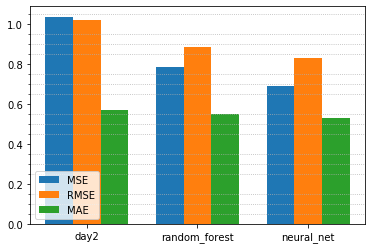

In [68]:
mse_list = [day2['MSE'],forest_gs_result_list['MSE'], neural_net_result_list['MSE']]
rmse_list = [day2['RMSE'], forest_gs_result_list['RMSE'], neural_net_result_list['RMSE']]
mae_list = [day2['MAE'], forest_gs_result_list['MAE'], neural_net_result_list['MAE']]
 
left = np.arange(len(mse_list))
labels = ['day2', 'random_forest', 'neural_net']

width = 0.25
 
plt.bar(left, mse_list, width=width, align='center', label="MSE")
plt.bar(left+width, rmse_list, width=width, align='center', label="RMSE")
plt.bar(left+width*2, mae_list, width=width, align='center', label="MAE")

plt.legend(loc='lower left')
plt.xticks(left + width, labels)
plt.gca().yaxis.set_minor_locator(tick.MultipleLocator(0.05))
plt.grid(linestyle='dotted', which='minor')
plt.show()

In [69]:
result = pd.DataFrame([mse_list, rmse_list, mae_list], index=["MSE", "RMSE", "MAE"]).T
result.index = ["DAY2(線形回帰)","ランダムフォレスト","ニューラルネットワーク"]
display(result)

,MSE,RMSE,MAE
DAY2(線形回帰),1.035788,1.017737,0.569030
ランダムフォレスト,0.786111,0.886629,0.547566
ニューラルネットワーク,0.690849,0.831173,0.530571


各指標ともに DAY2>ランダムフォレスト>ニューラルネットワーク の順に精度がよい

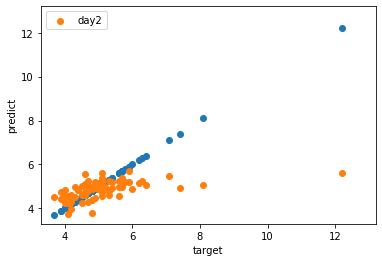

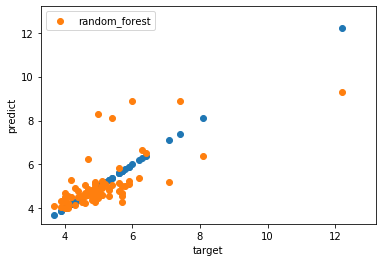

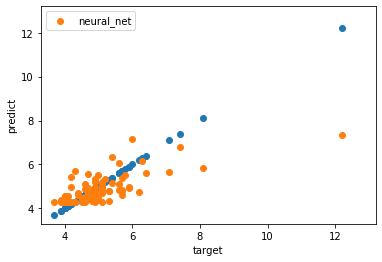

In [70]:
plt.scatter(target_test, target_test)
plt.scatter(target_test, day2_result, label='day2')
plt.xlim(target.min(), target.max()+1)
plt.ylim(target.min(), target.max()+1)
plt.xlabel("target")
plt.ylabel("predict")
plt.legend()
plt.show()

plt.scatter(target_test, target_test)
plt.scatter(target_test, forest_gs_result, label='random_forest')
plt.xlim(target.min(), target.max()+1)
plt.ylim(target.min(), target.max()+1)
plt.xlabel("target")
plt.ylabel("predict")
plt.legend()
plt.show()

plt.scatter(target_test, target_test)
plt.scatter(target_test, model2.predict(data_test), label=('neural_net'))
plt.xlim(target.min(), target.max()+1)
plt.ylim(target.min(), target.max()+1)
plt.xlabel("target")
plt.ylabel("predict")
plt.legend()
plt.show()

精度のいいものほどまとまっていて45度に近い

大きい値に外れ値が多いため元のデータを見てみる

In [71]:
display(df[df['consume'] > 7])
display(df.head(n=10))

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
37,4.9,7.4,26,21.5,6,NaN,1,0,0,0,NaN,NaN
45,2.0,9.9,21,21.5,4,NaN,0,0,0,0,NaN,NaN
60,2.9,7.9,18,21.5,9,AC rain,0,1,1,0,NaN,NaN
61,2.1,12.2,23,21.5,9,NaN,0,1,1,0,NaN,NaN
112,5.1,8.7,21,23.5,5,NaN,0,0,0,0,NaN,NaN
147,1.7,10.8,14,21.5,10,rain,1,0,1,0,NaN,NaN
160,5.1,8.1,39,21.5,4,NaN,1,0,0,0,NaN,NaN
181,12.3,7.1,52,22.5,0,AC snow,1,1,1,0,NaN,NaN
198,2.9,7.4,24,21.5,14,NaN,0,0,0,0,NaN,NaN
206,2.4,9.0,26,20.0,10,NaN,0,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,1,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,1,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,1,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,1,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,1,0,0,0,NaN,NaN
5,8.3,6.4,50,21.5,10,NaN,1,0,0,0,NaN,NaN
6,7.8,4.4,43,21.5,11,NaN,1,0,0,0,NaN,NaN
7,12.3,5.0,40,21.5,6,NaN,1,0,0,0,NaN,NaN
8,4.9,6.4,26,21.5,4,NaN,1,0,0,0,NaN,NaN
9,11.9,5.3,30,21.5,9,NaN,1,0,0,0,NaN,NaN


consumeが7より大きいものは12個しかないうえに、consume以外の値は他と大差がないため、異常値として除去する

In [14]:
df2 = df[df['consume'] < 7]
target = df2['consume']
data = df2.loc[:, ['distance', "speed", 'temp_inside' , 'temp_outside', 'gas_type', 'AC', 'rain', 'sun']]
(data_train, data_test, target_train, target_test) = train_test_split(data, target, test_size=0.2, random_state=666)
data_train = (data_train - data_train.mean()) / data_train.std()
data_test = (data_test - data_test.mean()) / data_test.std()

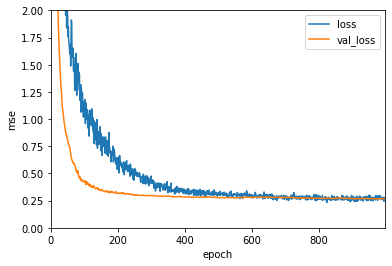

{'MSE': 0.26829758, 'RMSE': 0.5179745, 'MAE': 0.43910304}


In [40]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(666)
rn.seed(666)
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
tf.set_random_seed(666)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

model3 = Sequential()
model3.add(Dense(8, activation='relu', 
                 kernel_initializer=tf.keras.initializers.he_normal(seed=666), 
                 kernel_regularizer=keras.regularizers.l2(best_param[0]), 
                 input_dim=len(data_train.keys())))
model3.add(Dropout(best_param[1], seed=666))
model3.add(Dense(1))

optimizer = Adadelta()

model3.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mse', 'mae'])

fit3 = model3.fit(data_train, target_train,
          epochs=1000,
          batch_size=16,
          validation_data=(data_test, target_test),
          verbose=0)

df_nnresult3 = pd.DataFrame(fit3.history)

df_nnresult3[['loss', 'val_loss']].plot()
plt.ylabel("mse")
plt.xlabel("epoch")
plt.ylim(0, 2)
plt.show()

mse = model3.evaluate(data_test, target_test, verbose=0)[1]
rmse = np.sqrt(mse)
mae = model3.evaluate(data_test, target_test, verbose=0)[2]
neural_net_result_list3 = ({"MSE":mse, "RMSE":rmse, "MAE":mae})
print(neural_net_result_list3)

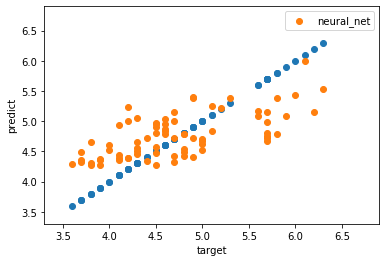

In [41]:
plt.scatter(target_test, target_test)
plt.scatter(target_test, model3.predict(data_test), label=('neural_net'))
plt.xlim(target.min(), target.max())
plt.ylim(target.min(), target.max())
plt.xlabel("target")
plt.ylabel("predict")
plt.legend()
plt.show()

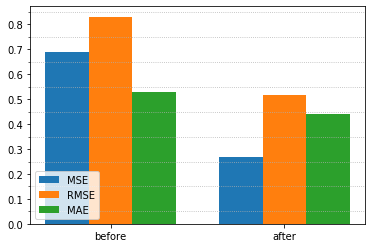

In [75]:
mse_list = [neural_net_result_list['MSE'], neural_net_result_list3['MSE']]
rmse_list = [neural_net_result_list['RMSE'], neural_net_result_list3['RMSE']]
mae_list = [neural_net_result_list['MAE'], neural_net_result_list3['MAE']]

left = np.arange(len(mse_list))
labels = ['before', 'after']

width = 0.25
 
plt.bar(left, mse_list, width=width, align='center', label="MSE")
plt.bar(left+width, rmse_list, width=width, align='center', label="RMSE")
plt.bar(left+width*2, mae_list, width=width, align='center', label="MAE")

plt.legend(loc='lower left')
plt.xticks(left + width, labels)
plt.gca().yaxis.set_minor_locator(tick.MultipleLocator(0.05))
plt.grid(linestyle='dotted', which='minor')
plt.show()

誤差は減ったけどスケールが違うし苦手なデータを無視しただけって考え方もあるからあんまりよくない気がする